In [1]:
import os

# Limit OpenMP and MKL threads to 1
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"


In [2]:
# Import the PyTorch library for deep learning.
import torch
torch.set_num_threads(1)
# Import the neural network module from PyTorch.
import torch.nn as nn

# Import NumPy for numerical operations.
import numpy as np

# Import Matplotlib for plotting.
import matplotlib.pyplot as plt
# %matplotlib inline

# Import the display module from IPython for interactive display.
from IPython import display

# # Set the matplotlib format to SVG for inline display in Jupyter Notebook.
# from matplotlib_inline.backend_inline import set_matplotlib_formats
# set_matplotlib_formats('svg')


In [13]:
# Define parameters for data generation.
num_samples_per_cluster = 100  # Number of data points per cluster.
data_blur = 1  # Degree of data point spread within each cluster.

# Define the center coordinates for cluster A and cluster B.
cluster_A_center = [1, 1]
cluster_B_center = [5, 1]

# Generate data for cluster A and B with random noise.
cluster_A_data = [cluster_A_center[0] + np.random.randn(num_samples_per_cluster) * data_blur,
                  cluster_A_center[1] + np.random.randn(num_samples_per_cluster) * data_blur]

cluster_B_data = [cluster_B_center[0] + np.random.randn(num_samples_per_cluster) * data_blur,
                  cluster_B_center[1] + np.random.randn(num_samples_per_cluster) * data_blur]

# Create true labels for the generated data (0 for cluster A and 1 for cluster B).
true_labels_np = np.vstack((np.zeros((num_samples_per_cluster, 1)), np.ones((num_samples_per_cluster, 1))))

# Concatenate data from both clusters into a data matrix.
data_np = np.hstack((cluster_A_data, cluster_B_data)).T

# Convert the data matrix to a PyTorch tensor with float datatype.
data = torch.tensor(data_np).float()

# Convert the true labels to a PyTorch tensor with float datatype.
true_labels = torch.tensor(true_labels_np).float()




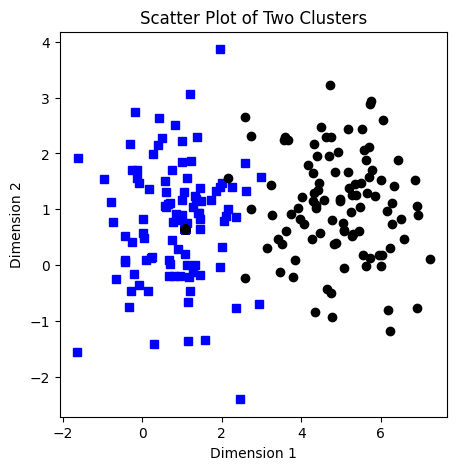

In [14]:
data_np = data_np.astype(np.float32)  # Ensure NumPy dtype is float32
true_labels_np = true_labels.numpy()  # Convert PyTorch tensor to NumPy

plt.figure(figsize=(5, 5))
plt.plot(data_np[np.where(true_labels_np == 0), 0], 
         data_np[np.where(true_labels_np == 0), 1], 'bs')
plt.plot(data_np[np.where(true_labels_np == 1), 0], 
         data_np[np.where(true_labels_np == 1), 1], 'ko')
plt.title('Scatter Plot of Two Clusters')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

In [15]:
import torch.nn.functional as F

In [16]:
# Define a custom function to create the ANN model.
def create_custom_ann_model(learning_rate):
    # Define the architecture of the neural network model.
    custom_ann_model = nn.Sequential(
        nn.Linear(2, 1),   # Input layer with 2 input features and 1 output neuron.
        nn.ReLU(),         # Rectified Linear Unit (ReLU) activation function.
        nn.Linear(1, 1)    # Output layer with 1 neuron.
        # Explanation: This defines a simple feedforward neural network with one hidden layer.
    )

    # Define the loss function for training the model.
    loss_function = nn.BCEWithLogitsLoss()
    # Explanation: Binary Cross-Entropy Loss with Logits (BCEWithLogitsLoss) is used for binary classification problems.

    # Define the optimizer to update the model parameters during training.
    custom_optimizer = torch.optim.SGD(custom_ann_model.parameters(), lr=learning_rate)
    # Explanation: Stochastic Gradient Descent (SGD) optimizer is used to update the model weights.

    # Return the constructed model, loss function, and optimizer.
    return custom_ann_model, loss_function, custom_optimizer


In [17]:
# Define a fixed number of training epochs.
num_epochs = 1000

# Define a function to train the custom ANN model.
def train_custom_ann_model(custom_model):
    # Initialize a tensor to store the losses during training.
    training_losses = torch.zeros(num_epochs)

    # Loop over epochs for training.
    for epoch in range(num_epochs):
        # Forward pass: Compute predictions using the custom model.
        predicted_labels = custom_model(data)

        # Compute the loss using the defined loss function.
        loss = loss_function(predicted_labels, true_labels)
        training_losses[epoch] = loss

        # Backpropagation: Zero the gradients, perform backward pass, and update model parameters.
        custom_optimizer.zero_grad()
        loss.backward()
        custom_optimizer.step()

    # Final forward pass to make predictions after training.
    final_predictions = custom_model(data)

    # Calculate and report the total accuracy of the model.
    accuracy = 100 * torch.mean(((final_predictions > 0) == true_labels).float())
    log_loss = F.binary_cross_entropy_with_logits(final_predictions, true_labels.float())

    return training_losses, final_predictions, accuracy, log_loss


Final accuracy: 50%
Final log loss: 0.694048%


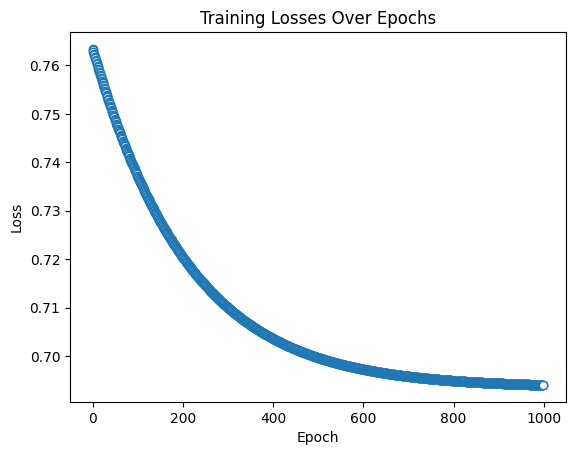

In [18]:
# Create the custom ANN model, loss function, and optimizer with a specific learning rate.
custom_ann_model, loss_function, custom_optimizer = create_custom_ann_model(0.01)

# Train the custom ANN model using the training function.
training_losses, final_predictions, total_accuracy, total_log_loss = train_custom_ann_model(custom_ann_model)

# Print the final accuracy after training.
print('Final accuracy: %g%%' % total_accuracy)
print('Final log loss: %g%%' % total_log_loss)

# Plot the training losses over epochs.
plt.plot(training_losses.detach(), 'o', markerfacecolor='w', linewidth=0.1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses Over Epochs')
plt.show()


In [19]:
# Define a range of learning rates to test.
learning_rates_to_test = np.linspace(0.001, 0.1, 40)

# Initialize lists to store accuracy and losses for different learning rates.
accuracies_by_learning_rate = []
log_losses_by_learning_rate = []
all_losses = np.zeros((len(learning_rates_to_test), num_epochs))

# Loop through the learning rates.
for i, lr in enumerate(learning_rates_to_test):
    # Create and train a custom ANN model for each learning rate.
    custom_ann_model, loss_function, custom_optimizer = create_custom_ann_model(lr)
    losses, predictions, accuracy, log_loss = train_custom_ann_model(custom_ann_model)

    # Store the results.
    accuracies_by_learning_rate.append(accuracy)
    log_losses_by_learning_rate.append(log_loss)
    all_losses[i, :] = losses.detach()


/tmp/ipykernel_29428/3170389593.py:18: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  all_losses[i, :] = losses.detach()


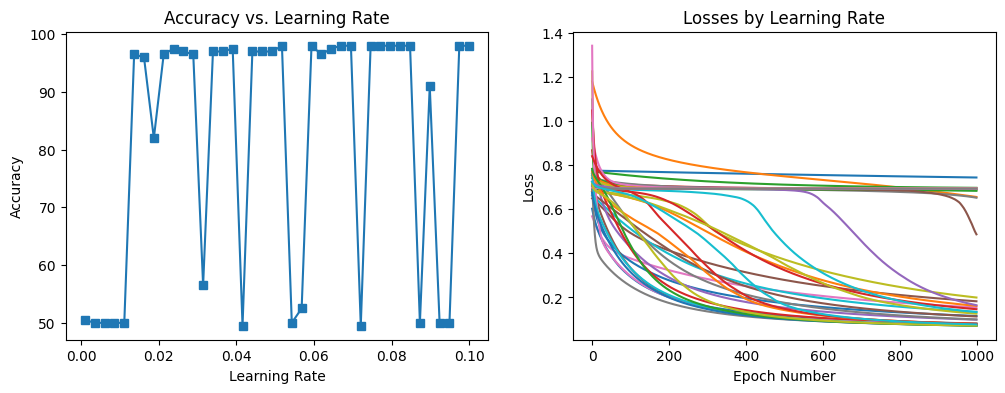

In [21]:
# Plot the results: Accuracy vs. Learning Rate and Losses by Learning Rate.
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(learning_rates_to_test, accuracies_by_learning_rate, 's-')
ax[0].set_xlabel('Learning Rate')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Accuracy vs. Learning Rate')

ax[1].plot(all_losses.T)
ax[1].set_title('Losses by Learning Rate')
ax[1].set_xlabel('Epoch Number')
ax[1].set_ylabel('Loss')
plt.show()


In [12]:
# Calculate the proportion of runs where the model had at least 70% accuracy.
proportion_above_70 = sum(torch.tensor(accuracies_by_learning_rate) > 70) / len(accuracies_by_learning_rate)
proportion_above_70


tensor(0.6250)

In [22]:
# Number of times to iterate through the experiment with different initializations.
num_experiments = 50

# Create a matrix to store all accuracy results for meta-experiment.
accuracy_meta_experiment = np.zeros((num_experiments, len(learning_rates_to_test)))
log_loss_meta_experiment = np.zeros((num_experiments, len(learning_rates_to_test)))

# Reduce the number of epochs for faster computation.
num_epochs = 500

# Perform the meta-experiment.
for experiment in range(num_experiments):
    for i, lr in enumerate(learning_rates_to_test):
        # Create and train a custom ANN model for each learning rate.
        custom_ann_model, loss_function, custom_optimizer = create_custom_ann_model(lr)
        losses, predictions, accuracy, log_loss = train_custom_ann_model(custom_ann_model)

        # Store the accuracy results for each experiment.
        accuracy_meta_experiment[experiment, i] = accuracy
        log_loss_meta_experiment[experiment, i] = log_loss


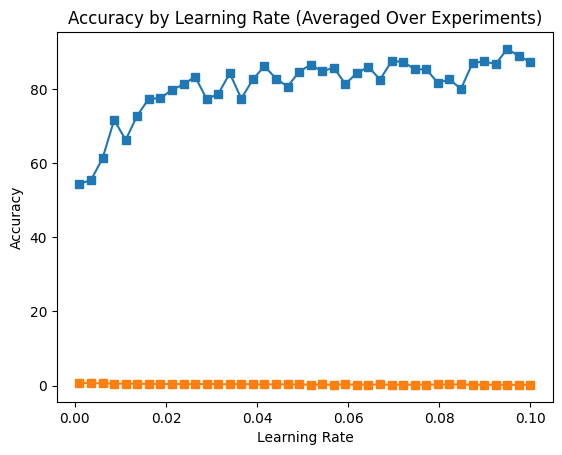

In [23]:
# Plot the averaged results over experiments.
plt.plot(learning_rates_to_test, np.mean(accuracy_meta_experiment, axis=0), 's-')
plt.plot(learning_rates_to_test, np.mean(log_loss_meta_experiment, axis=0), 's-')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title('Accuracy by Learning Rate (Averaged Over Experiments)')
plt.show()

In [ ]:
# 1) The closeness of the qwerties groups is determined by the XY locations of the centroids, and by the blur parameter.
#    Try increasing or decreasing the blur (e.g., to 2 or .5). How does this affect the number of times that the model
#    successfully learned to categorize the two conditions?
# 
# 2) The mean of a set of numbers is easily interpretable only if the data are roughly normally or uniformly distributed 
#    (see lecture "Mean and variance" in Math section). Do you think the mean is a valid description of the performance
#    of the model's accuracy in the meta-experiment? Use a different metric (e.g., one we discussed in this video!) and 
#    plot that result on the same graph as the average. You might need to do some normalization to get them in the same 
#    range. Does this alternative method lead to a different conclusion?
# 
# 3) Related to the previous comment, perhaps showing an image of the performance (variable accMeta) would be more 
#    appropriate. Create a heat map that shows learning rate on the x-axis, experiment repetitions on the y-axis, and
#    the final accuracy in color. Label the axes and specify suitable color boundaries.
# 